In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
def remove_outliers_IQR(data, limit):
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    outliers = data[np.isnan(data_cp)]
    
    print('Removed %d / %d points (%.1f percent)' % (len(outliers[~np.isnan(outliers)]), len(data), (len(outliers[~np.isnan(outliers)])/len(data))*100))
    return data_cp

In [3]:
### load the SWOT and GNSS buoy data

swot = xr.open_mfdataset('SWOT_products_at_buoys.nc')
buoy = xr.open_dataset('GNSS_at_SWOT_times.nc')

# load mean SSH from buoys
mean_GNSS = np.genfromtxt('GNSS_mean_SSH.csv', delimiter=",")

# load coordinates
coords = np.genfromtxt('buoy_locations_FSP_UTM.csv', delimiter=",")

### apply corrections to SWOT SSH to make it comparable to buoys (solid earth, SE of pole tide, ocean tidal loading)

h2 = 0.6207
k2 = 0.302
pole_factor = h2 / (1 + k2)

swot['ssh_comparison'] = swot.PGC_ssh_karin_2 - swot.PGC_solid_earth_tide - swot.PGC_load_tide_fes - swot.PGC_pole_tide * pole_factor

# apply quality flag, preserving points at buoy closest to the coast which would otherwise be discarded
swot['ssh_comparison'] = swot['ssh_comparison'].where(swot.PGC_ssh_karin_2_qual < 257)

# apply quality flag to PGC0 corrections
swot['PGC_height_cor_xover'] = swot['PGC_height_cor_xover'].where(swot.PGC_height_cor_xover_qual < 1)
swot['ssh_comparison'] = swot.PGC_height_cor_xover.values + swot.ssh_comparison


# apply quality flag to buoy
buoy['ssh'] = buoy['ssh'].where(buoy.ssh_quality <2)

# rename data
SWOT = swot.ssh_comparison.values
GNSS = buoy.ssh.values


In [4]:
### convert m to cm and remove the mean SSH

GNSS = GNSS*100
SWOT = SWOT*100
mean_GNSS = mean_GNSS*100

for i in range(np.shape(GNSS)[0]):
    SWOT[i, :] = SWOT[i, :] - mean_GNSS[i]    
    GNSS[i, :] = GNSS[i, :] - mean_GNSS[i]


In [5]:
### discard times without complete data (i.e. we want nine data points for every variogram, consistent between datasets)

# print shape
print("Shape of GNSS before NaN removal: ", np.shape(GNSS))
print("Shape of SWOT before NaN removal: ", np.shape(SWOT))

# print number of nans in each
print("Number of NaNs in GNSS: ", len(GNSS[np.isnan(GNSS)]))
print("Number of NaNs in SWOT: ", len(GNSS[np.isnan(SWOT)]))

GNSS_full = []
SWOT_full = []


for i in range(len(GNSS[0, :])):    

    gnss_row = GNSS[:, i]
    swot_row = SWOT[:, i]

    if len(gnss_row[np.isnan(gnss_row)]) == 0:
        if len(swot_row[np.isnan(swot_row)]) == 0:
            GNSS_full.append(gnss_row)
            SWOT_full.append(swot_row)
           

GNSS_full = np.array(GNSS_full).T
SWOT_full = np.array(SWOT_full).T

# print shape
print("\nShape of GNSS after NaN removal: ", (np.shape(GNSS_full)))
print("Shape of SWOT after NaN removal: ", (np.shape(SWOT_full)))


# print number of nans in each
print("Check there are now zero nans: ", len(GNSS_full[np.isnan(GNSS_full)]))
print("Check there are now zero nans: ", len(SWOT_full[np.isnan(SWOT_full)]))


Shape of GNSS before NaN removal:  (9, 96)
Shape of SWOT before NaN removal:  (9, 96)
Number of NaNs in GNSS:  98
Number of NaNs in SWOT:  39

Shape of GNSS after NaN removal:  (9, 48)
Shape of SWOT after NaN removal:  (9, 48)
Check there are now zero nans:  0
Check there are now zero nans:  0


In [6]:
# calculate pairwise diffs

cycles = 48
GNSS_diffs_sq = np.ones((36, cycles))*np.nan
SWOT_diffs_sq = np.ones((36, cycles))*np.nan

distances = np.ones((36))*np.nan

# Generate unique pairs of indices
pairs = [(i, j) for i in range(9) for j in range(i + 1, 9)]

# Calculate pairwise differences for the unique pairs
for idx, (i, j) in enumerate(pairs):
    GNSS_diffs_sq[idx, :] = ((GNSS_full[i, :] - GNSS_full[j, :]))**2
    SWOT_diffs_sq[idx, :] = ((SWOT_full[i, :] - SWOT_full[j, :]))**2
    distances[idx] = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)

# convert distances to km
distances = distances/1000

# sort data by distance
sort_idx = np.argsort(distances)
distances = distances[sort_idx]
GNSS_diffs_sq = GNSS_diffs_sq[sort_idx]
SWOT_diffs_sq = SWOT_diffs_sq[sort_idx]


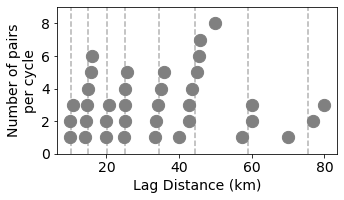

In [7]:
### define lag list and plot

lag_list = np.array((np.nanmean(distances[0:3]),
                     np.nanmean(distances[3:9]),
                     np.nanmean(distances[9:12]),
                     np.nanmean(distances[12:17]),
                     np.nanmean(distances[17:22]),
                     np.nanmean(distances[22:30]),
                     np.nanmean(distances[30:33]),
                     np.nanmean(distances[33:36])))


fig, ax = plt.subplots(1, figsize=(5,3))

for i in range(len(lag_list)):
    ax.axvline(x=lag_list[i], ls='--', c='k', alpha=0.3, zorder=1)

plt.scatter(distances[0:3], range(1,4), s=150, c='grey', zorder=10)
plt.scatter(distances[3:9], range(1,7), s=150, c='grey', zorder=10)
plt.scatter(distances[9:12], range(1,4), s=150, c='grey', zorder=10)
plt.scatter(distances[12:17], range(1,6), s=150, c='grey', zorder=10)
plt.scatter(distances[17:22], range(1,6), s=150, c='grey', zorder=10)
plt.scatter(distances[22:30], range(1,9), s=150, c='grey', zorder=10)
plt.scatter(distances[30:33], range(1,4), s=150, c='grey', zorder=10)
plt.scatter(distances[33:36], range(1,4), s=150, c='grey', zorder=10)

ax.set_ylabel('Number of pairs\nper cycle')
ax.set_xlabel('Lag Distance (km)')
ax.set_ylim(0,9)
plt.tight_layout()
plt.show()



In [8]:
### calculate semivar

no_lags = len(lag_list)

GNSS_semivar = np.ones((no_lags, cycles))*np.nan
SWOT_semivar = np.ones((no_lags, cycles))*np.nan

for i in range(cycles):
    tmp_GNSS = GNSS_diffs_sq[:,i]
    tmp_SWOT = SWOT_diffs_sq[:,i]
       
    
    GNSS_semivar[:,i] = np.array(((0.5 * np.nanmean(tmp_GNSS[0:3])), 
                (0.5 * np.nanmean(tmp_GNSS[3:9])), 
                (0.5 * np.nanmean(tmp_GNSS[9:12])),
                (0.5 * np.nanmean(tmp_GNSS[12:17])),
                (0.5 * np.nanmean(tmp_GNSS[17:22])),
                (0.5 * np.nanmean(tmp_GNSS[22:30])),
                (0.5 * np.nanmean(tmp_GNSS[30:33])), 
                (0.5 * np.nanmean(tmp_GNSS[33:36]))))
    
    SWOT_semivar[:,i] = np.array(((0.5 * np.nanmean(tmp_SWOT[0:3])), 
                (0.5 * np.nanmean(tmp_SWOT[3:9])), 
                (0.5 * np.nanmean(tmp_SWOT[9:12])),
                (0.5 * np.nanmean(tmp_SWOT[12:17])),
                (0.5 * np.nanmean(tmp_SWOT[17:22])),
                (0.5 * np.nanmean(tmp_SWOT[22:30])),
                (0.5 * np.nanmean(tmp_SWOT[30:33])), 
                (0.5 * np.nanmean(tmp_SWOT[33:36]))))
    
    
GNSS_semivar_mean = np.nanmean(GNSS_semivar, axis=1)
SWOT_semivar_mean = np.nanmean(SWOT_semivar, axis=1)


In [9]:
### calculate standard error of the mean

SWOT_std = np.nanstd(SWOT_semivar, axis=1)
SWOT_SE = SWOT_std/np.sqrt(cycles)

GNSS_std = np.nanstd(GNSS_semivar, axis=1)
GNSS_SE = GNSS_std/np.sqrt(cycles)

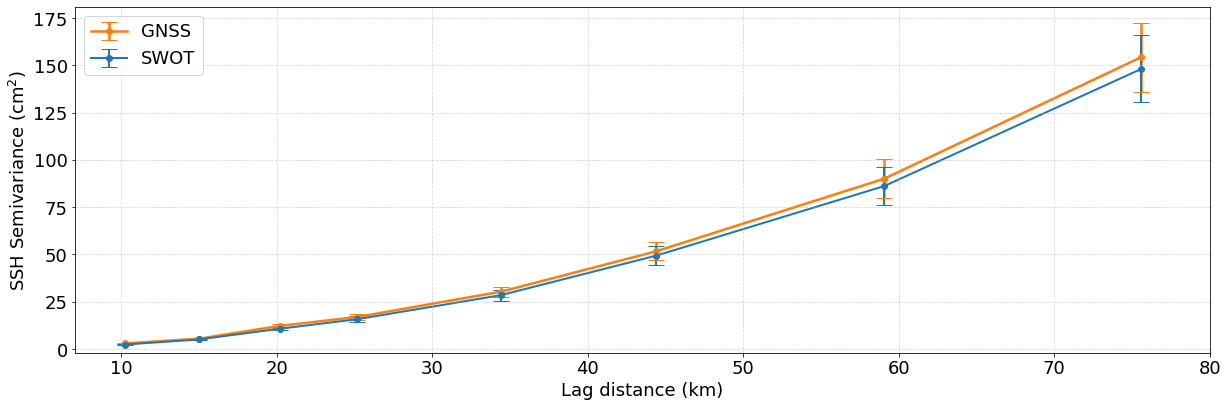

In [10]:
# plot the average variogram

fig_width = 17.4
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, figsize=(fig_width, 6))
ax.errorbar(lag_list, GNSS_semivar_mean, yerr=GNSS_SE, capsize=8, c='C1', marker='o', label='GNSS', zorder=1, lw=2.5)
ax.errorbar(lag_list, SWOT_semivar_mean, yerr=SWOT_SE, capsize=8, c='C0', marker='o', label='SWOT', zorder=1, lw=2)
ax.set_xlabel('Lag distance (km)')
ax.set_ylabel('SSH Semivariance (cm$^2$)')
ax.set_ylim(-2,None)
ax.set_xlim(7, 80)
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

